<a href="https://colab.research.google.com/github/Lathika2006/AI-Driven-Cultural-Etiquette-Guide-/blob/main/Culture_Etiquette_Guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install transformers accelerate gradio pandas regex fuzzywuzzy python-Levenshtein


In [14]:
from transformers import pipeline

generator = pipeline(
    "text2text-generation",
    model="google/flan-t5-large",
    device_map="auto"
)

print("FLAN-T5-Large is ready!")


Device set to use cuda:0


FLAN-T5-Large is ready!


In [15]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

df = pd.read_csv("cleaned_production_dataset.csv")
df.head()


Saving cleaned_production_dataset.csv to cleaned_production_dataset (1).csv


,country,state_region,greetings,dining,dressing,gifting,religion,business,festival,vibe,etiquette_summary
0,Australia,Australian Capital Territory,Handshakes formal in professional settings,Diverse cuisines reflecting national capital,Formal business attire common in Canberra,"Books, wine, or small gifts appreciated","Christian, secular, and multicultural practices","Formal, policy-driven business culture","National Multicultural Festival, Floriade Canb...","casual, formal, tradition-focused",Here's something useful for your trip! People ...
1,Australia,General,casual greetings like 'G'day,tipping not obligatory but appreciated,smart casual for business,Small gifts or wine appreciated,"Predominantly Christian, but multicultural soc...","Direct, informal, punctual business style","Australia Day, ANZAC Day, multicultural festivals","casual, formal, tradition-focused",Glad you asked — happy to share a quick guide....
2,Australia,New South Wales,Friendly handshakes,Varied global cuisines,"Urban casual in Sydney, business suits in offices",Local wine or small gifts valued,Christian and multicultural faiths,"Fast-paced, direct business culture","Sydney Festival, Vivid Sydney","casual, tradition-focused",Here's something useful for your trip! People ...
3,Australia,Northern Territory,handshake respectful,Bush foods and multicultural cuisines,"Light, practical clothing",Local crafts or small gifts appreciated,Strong Indigenous traditions alongside Christi...,Respectful and culturally aware business style,"Darwin Festival, Parrtjima Light Festival","casual, tradition-focused",Glad you asked — happy to share a quick guide....
4,Australia,Queensland,Warm greetings,Seafood and tropical fruits popular,Light clothing for warm climate,"Small, thoughtful gifts appreciated",Christian and Indigenous traditions,Relaxed but punctual business style,"Brisbane Festival, Gold Coast events","casual, tradition-focused",Happy to share this with you! People commonly ...


In [16]:
import re

def detect_intent(query):
    query = query.lower()

    mapping = {
        "greetings": ["greet", "greeting", "say hello"],
        "dining": ["dining", "eat", "food rules", "table manners"],
        "dressing": ["dress", "clothing", "what to wear"],
        "gifting": ["gift", "present", "gift giving"],
        "taboos": ["avoid", "taboo", "not allowed"],
        "religion": ["religion", "belief"],
        "business": ["business", "work culture", "meeting"],
        "festival": ["festival", "holiday", "celebration"],
    }

    for feature, words in mapping.items():
        for w in words:
            if w in query:
                return feature

    return "full"


In [17]:
from fuzzywuzzy import process

def find_location(user_input):
    options = df["country"].tolist() + df["state_region"].tolist()
    match, score = process.extractOne(user_input, options)
    return match


In [18]:
def build_prompt(feature, row):

    place = f"{row['state_region']}, {row['country']}"
    info = row[feature]

    # FULL ETIQUETTE
    if feature == "full":
        combined = f"""
greetings: {row['greetings']}
dining: {row['dining']}
dressing: {row['dressing']}
gifting: {row['gifting']}
taboos: {row['taboos']}
religion: {row['religion']}
business: {row['business']}
festivals: {row['festival']}
"""
        return f"""
Expand the following cultural information into a warm, friendly paragraph
for a traveler visiting {place}.
Add meaning, context, friendliness, and smooth explanation.
Do NOT copy the text directly. Rewrite everything in natural English.

{combined}
"""

    # SINGLE FEATURE (greetings, dining, dressing…)
    return f"""
You are rewriting cultural information for a traveler visiting {place}.

Take this short text:
"{info}"

Now expand it into 3–4 warm, friendly, conversational sentences.
Add cultural context, meaning, politeness, why people do it,
and how visitors can use it respectfully.

Do NOT copy the text exactly.
Do NOT repeat the quote.
Rewrite it naturally in rich, friendly English.
"""


In [19]:
def generate_etiquette(user_input):

    feature = detect_intent(user_input)
    location = find_location(user_input)

    row = df[(df["country"] == location) | (df["state_region"] == location)].iloc[0]

    prompt = build_prompt(feature, row)

    response = generator(
        prompt,
        max_length=300,
        temperature=0.9
    )[0]["generated_text"]

    return response


In [20]:
import gradio as gr

# Chatbot UI CSS
css_code = """
/* Background */
body { background: #f2f4f7; }

/* Title */
#title {
    font-size: 30px;
    font-weight: bold;
    text-align:center;
    color: white;
}

/* Chat window */
.gr-chatbot {
    height: 450px !important;
    background: #ffffff !important;
    border-radius: 12px !important;
    border: 2px solid #d1d5db !important;
}

/* Button */
.gr-button {
    background: #ff6600 !important;
    color: white !important;
    border-radius: 12px !important;
    padding: 10px 22px !important;
    font-size: 18px !important;
}
"""

# Chatbot logic (ChatGPT-style)
def chat_interface(message, history):
    reply = generate_etiquette(message)
    history.append({"role": "user", "content": message})
    history.append({"role": "assistant", "content": reply})
    return history, history


with gr.Blocks(css=css_code) as app:

    gr.Markdown("<h1 id='title'>🌍 AI Cultural Etiquette Guide</h1>")
    gr.Markdown("Enter your questions and receive friendly cultural etiquette guidance.")

    chatbot = gr.Chatbot(type="messages", elem_classes="gr-chatbot")

    with gr.Row():
        user_input = gr.Textbox(
            placeholder="Ask anything about a place...",
            label="Your Question"
        )
        submit_btn = gr.Button("Submit")

    submit_btn.click(
        chat_interface,
        inputs=[user_input, chatbot],
        outputs=[chatbot, chatbot]
    )

app.launch()


/tmp/ipython-input-3404002383.py:42: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(css=css_code) as app:
/tmp/ipython-input-3404002383.py:47: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False if you want to disable tags in your chatbot.
  chatbot = gr.Chatbot(type="messages", elem_classes="gr-chatbot")


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://684136872815a7ebc0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [21]:
def detect_intent(query):
    query = query.lower()

    if any(word in query for word in ["greet", "hello", "vanakkam", "hi", "salutation"]):
        return "greeting"
    if any(word in query for word in ["food", "dining", "eat", "meal", "cuisine"]):
        return "dining"
    if any(word in query for word in ["dress", "attire", "clothing", "outfit"]):
        return "dressing"
    if any(word in query for word in ["festival", "celebration", "occasion"]):
        return "festival"
    if any(word in query for word in ["business", "work culture", "meeting"]):
        return "business"
    if any(word in query for word in ["taboo", "avoid", "mistake"]):
        return "taboo"

    return "other"


In [22]:
import pandas as pd

intent_test = pd.DataFrame({
    "question": [
        "What is the greeting in Tamil Nadu?",
        "How do people greet in Japan?",
        "Tell me the dining etiquette in Kerala",
        "What food habits are common in Japan?",
        "How do people dress in Kerala?",
        "What is the traditional attire in Tamil Nadu?",
        "What festivals are celebrated in Tamil Nadu?",
        "Tell me popular festivals in Japan",
        "What is business etiquette in Japan?",
        "How should we behave in a meeting in Kerala?",
        "What taboos should I avoid in Japan?",
        "What things are considered rude in Tamil Nadu?"
    ],
    "expected_intent": [
        "greeting",
        "greeting",
        "dining",
        "dining",
        "dressing",
        "dressing",
        "festival",
        "festival",
        "business",
        "business",
        "taboo",
        "taboo"
    ]
})

intent_test


,question,expected_intent
0,What is the greeting in Tamil Nadu?,greeting
1,How do people greet in Japan?,greeting
2,Tell me the dining etiquette in Kerala,dining
3,What food habits are common in Japan?,dining
4,How do people dress in Kerala?,dressing
5,What is the traditional attire in Tamil Nadu?,dressing
6,What festivals are celebrated in Tamil Nadu?,festival
7,Tell me popular festivals in Japan,festival
8,What is business etiquette in Japan?,business
9,How should we behave in a meeting in Kerala?,business


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

true_labels = []
pred_labels = []

for i, row in intent_test.iterrows():
    q = row["question"]
    expected = row["expected_intent"]

    predicted = detect_intent(q)

    true_labels.append(expected)
    pred_labels.append(predicted)

    print(f"Q: {q}")
    print(f"Expected Intent: {expected}")
    print(f"Predicted Intent: {predicted}")
    print("--------------------------------------------------")

accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)

print("\nFINAL INTENT DETECTION PERFORMANCE:")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)


Q: What is the greeting in Tamil Nadu?
Expected Intent: greeting
Predicted Intent: greeting
--------------------------------------------------
Q: How do people greet in Japan?
Expected Intent: greeting
Predicted Intent: greeting
--------------------------------------------------
Q: Tell me the dining etiquette in Kerala
Expected Intent: dining
Predicted Intent: dining
--------------------------------------------------
Q: What food habits are common in Japan?
Expected Intent: dining
Predicted Intent: dining
--------------------------------------------------
Q: How do people dress in Kerala?
Expected Intent: dressing
Predicted Intent: dressing
--------------------------------------------------
Q: What is the traditional attire in Tamil Nadu?
Expected Intent: dressing
Predicted Intent: dressing
--------------------------------------------------
Q: What festivals are celebrated in Tamil Nadu?
Expected Intent: festival
Predicted Intent: festival
---------------------------------------------

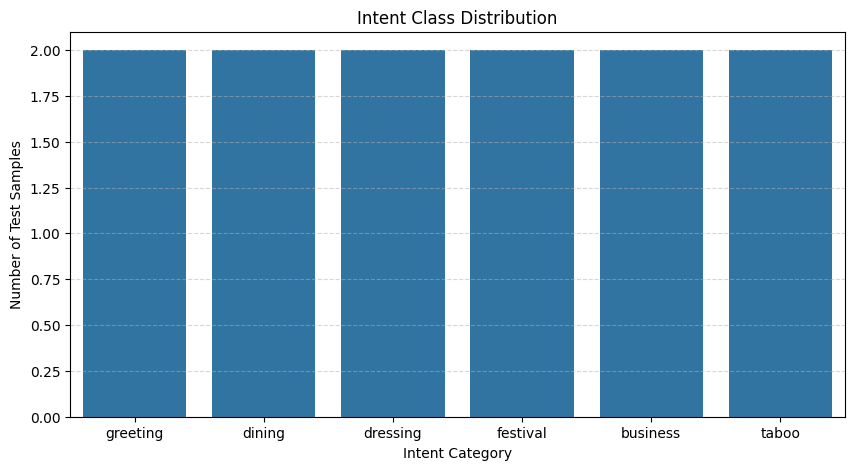

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count number of samples per intent in your evaluation dataset
intent_counts = intent_test['expected_intent'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x=intent_counts.index, y=intent_counts.values)

plt.title("Intent Class Distribution")
plt.xlabel("Intent Category")
plt.ylabel("Number of Test Samples")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()
